In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
import joblib
import shap
from sklearn.metrics import f1_score
import re
import seaborn as sns
shap.initjs()

In [2]:
os.chdir("../../Dataset/Merged")

In [3]:
dataset = pd.read_csv('MergedDataset.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()

dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Dataset di train:
(1593, 5588)
I malati sono:  695
I sani sono:  898

Dataset di test:
(520, 5588)
I malati sono:  245
I sani sono:  275


In [4]:
ensembleSoft = joblib.load('../../Modelli/DatasetFull/ensembleSoft.pkl')

Il calcolo della shap importance si fa come: <br>
shap_importance = np.abs(shap_values.values).mean(0) <br>
Ed è stato calcolato sulla macchina virtuale

<h1>Analisi XAI ensemble</h1>

In [4]:
limeexplanation = joblib.load('../../ShapValues/DatasetFull/ensemble_lime.pkl')
# limeSubExpl = joblib.load('../../ShapValues/DatasetFull/ensemble_subExp3.pkl').sp_explanations
# limeSubExplRed = joblib.load('../../ShapValues/DatasetFull/ensemble_subExp2.pkl').sp_explanations
ensemble_ablation = joblib.load("../../ShapValues/DatasetFull/ensemble_ablationScores.pkl")

In [24]:
def createMatrix(limeexplanation, flag=0):
    arr = []
    dict = {}
    regex_pattern = r'\b[A-Za-z_][A-Za-z0-9_-]*\b'

    for feature in x_train.columns:
        dict[feature] = 0

    if flag == 1:
        for exp in limeexplanation:
            for feature, val in exp.as_list():
                match = re.search(regex_pattern, feature)

                #check
                if match[0] not in x_train.columns:
                    print(feature)
                    break

                dict[match[0]] = float(val)
            
            arr.append(list(dict.values()))
            
            dict={}
            for feature in x_train.columns:
                dict[feature] = 0
    else:
        i = 0
        for exp in limeexplanation:
            for label in exp.local_exp.keys():
                for feature, val in exp.as_list(label):
                    match = re.search(regex_pattern, feature)
                #check
                if match[0] not in x_train.columns:
                    print("Errore: ", feature, " mancante")
                    break

                dict[match[0]] = float(val)
            
            arr.append(list(dict.values()))
            
            dict={}
            for feature in x_train.columns:
                dict[feature] = 0

            i=i+1
    return arr

expl = createMatrix(limeexplanation, 1)
# subExpl = createMatrix(limeSubExpl)
# subExplRed = createDict(limeSubExplRed)

limeexplanation = None
limeSubExpl = None
limeSubExplRed = None

In [5]:
joblib.dump(expl, '../../ShapValues/DatasetFull/ensemble_expl.pkl')

NameError: name 'expl' is not defined

Calcolo la media dei valori assoluti per ogni feature

In [6]:
expl = joblib.load('../../ShapValues/DatasetFull/ensemble_expl.pkl')
expl_summary = np.abs(expl).mean(0)
expl_dictSummary = dict(zip(x_train.columns, expl_summary))

In [7]:
expl_summary = joblib.load('../../ShapValues/DatasetFull/ensemble_summary.pkl')
ensemble_ablation = joblib.load("../../ShapValues/DatasetFull/ensembleSoft_ablationScores.pkl")
expl_dictSummary = dict(zip(x_train.columns, expl_summary))

In [8]:
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

print(list(expl_sorted.values())[:100])
print(list(expl_sorted.keys())[:100])

ensemble_sorted_scores = dict(sorted(ensemble_ablation.items(), key=lambda item: item[1], reverse=True))
ensemble_bestFeatures = {key: value for key, value in ensemble_sorted_scores.items() if value > 1.0}
ensemble_worstFeatures = {key: value for key, value in ensemble_sorted_scores.items() if value < 1.0}

print("Le feature migliori sono: ", len(ensemble_bestFeatures), ensemble_bestFeatures)
print("Le feature rumorose sono: ", len(ensemble_worstFeatures), ensemble_worstFeatures)

print(list(ensemble_bestFeatures.keys()))
print(list(ensemble_worstFeatures.keys()))

[0.03780349553259745, 0.027153941970652597, 0.02448157608747148, 0.02282850285783097, 0.021578538865868968, 0.020819075818859816, 0.01771614625297542, 0.01509705539455005, 0.014063515121155102, 0.013174050015911109, 0.01264477833735621, 0.01245196647109851, 0.010688668235192423, 0.009882428645552797, 0.009376005674254981, 0.009210243189847898, 0.009070305088256991, 0.008445566173084736, 0.008106529145915194, 0.007912932067304214, 0.007653323470788014, 0.007566067025876768, 0.007155616283859478, 0.007038145080116645, 0.0070338684129011755, 0.0067317385045438955, 0.006530607193418699, 0.0065090839862550105, 0.006384572429708247, 0.006323692650797608, 0.006021249668463251, 0.005951652848345167, 0.005922917747476641, 0.005920313468188889, 0.005836008774500585, 0.005825617987215753, 0.005794349334114642, 0.005744613100081254, 0.0056816466016827655, 0.0056404783366714025, 0.005637131188200224, 0.0055628971748136495, 0.005532743071924623, 0.005500674984177998, 0.005481376253142992, 0.00546655

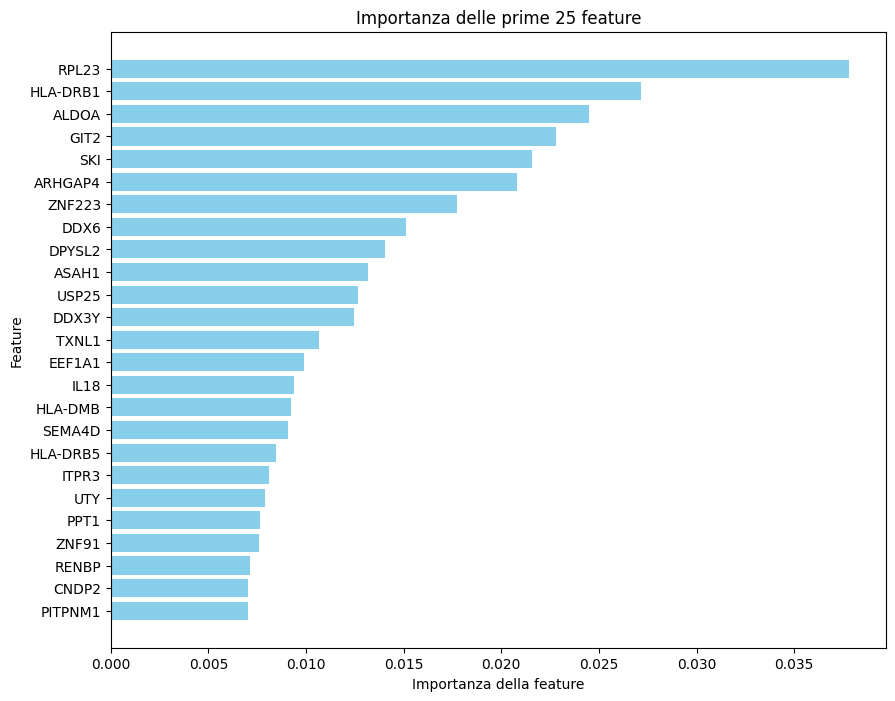

In [20]:
max_display = 25
top_features = list(expl_sorted.keys())[:max_display]
top_importances = list(expl_sorted.values())[:max_display]

# Crea il grafico a barre
plt.figure(figsize=(10, 8))
plt.barh(top_features[::-1], top_importances[::-1], color='skyblue')
plt.xlabel('Importanza della feature')
plt.ylabel('Feature')
plt.title('Importanza delle prime 25 feature')
plt.show()

Feature ritenute importanti sia dall'ablation che per importance

In [10]:
print([feature for feature in list(ensemble_bestFeatures.keys()) if feature in list(expl_sorted.keys())[:100]])

['HLA-DRB1', 'GIT2', 'USP25', 'CCNT1', 'ZNF223', 'DDX6', 'FBLN2', 'DDX3Y', 'HEXIM1']


Matrice di correlazione per i migliori 100 shap-importance

In [16]:
ensembleCorr = pd.DataFrame(expl, columns=x_train.columns)[list(expl_sorted.keys())[:100]].corr()
print(ensembleCorr)

             RPL23  HLA-DRB1     ALDOA      GIT2       SKI   ARHGAP4  \
RPL23     1.000000 -0.152222  0.161848  0.281170  0.235099  0.118694   
HLA-DRB1 -0.152222  1.000000  0.074446 -0.105344  0.036715 -0.126390   
ALDOA     0.161848  0.074446  1.000000  0.270487  0.093492  0.293529   
GIT2      0.281170 -0.105344  0.270487  1.000000  0.183362  0.265702   
SKI       0.235099  0.036715  0.093492  0.183362  1.000000  0.164969   
...            ...       ...       ...       ...       ...       ...   
NPAS3     0.166699 -0.164142  0.135810  0.069913  0.152912  0.129805   
UPK3A     0.014807  0.021420 -0.088776 -0.119121  0.039320 -0.116219   
TPM3      0.137687 -0.008050  0.046274  0.056873  0.116569 -0.047293   
ZBTB11   -0.077820  0.050863  0.188197  0.132708 -0.041299  0.111248   
KCTD13    0.110447 -0.049690  0.143821  0.162415  0.032411  0.267211   

            ZNF223      DDX6    DPYSL2     ASAH1  ...    HOXA10      MFN2  \
RPL23     0.294852  0.229282  0.209424  0.284984  ...  0.1

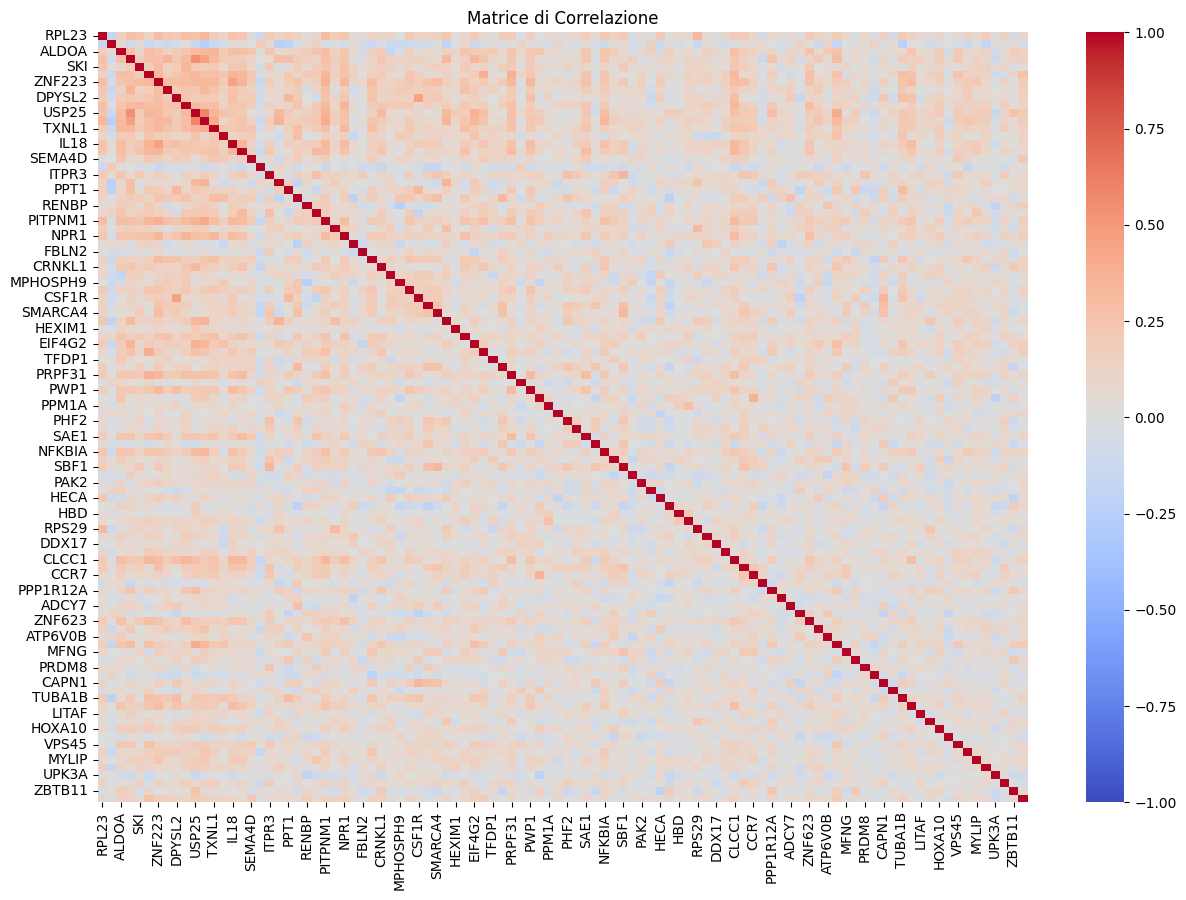

In [17]:
plt.figure(figsize=(15,10))
sns.heatmap(ensembleCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [18]:
ensemble_correlated_pairs = np.where(np.abs(ensembleCorr) >= 0.375)

# Print the correlated pairs
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        print(f"{ensembleCorr.index[i]} - {ensembleCorr.columns[j]}: {ensembleCorr.iloc[i, j]}")

GIT2 - USP25: 0.5418102576880957
GIT2 - DDX3Y: 0.45959441203321244
ARHGAP4 - LZTR1: 0.38928261201945596
ZNF223 - IL18: 0.45339232196413604
DPYSL2 - CSF1R: 0.4602517492072425
USP25 - GIT2: 0.5418102576880957
USP25 - DDX3Y: 0.60046097092386
USP25 - TMED5: 0.40285960616308447
DDX3Y - GIT2: 0.45959441203321244
DDX3Y - USP25: 0.60046097092386
DDX3Y - TXNL1: 0.40054187232558924
DDX3Y - PITPNM1: 0.4092487565376934
TXNL1 - DDX3Y: 0.40054187232558924
IL18 - ZNF223: 0.45339232196413604
PITPNM1 - DDX3Y: 0.4092487565376934
CSF1R - DPYSL2: 0.4602517492072425
LZTR1 - ARHGAP4: 0.38928261201945596
TMED5 - USP25: 0.40285960616308447


Matrice di correlazione per i migliori data dall'intersezione tra abalation e shap

{'AQP9', 'HEXIM1', 'NPAS3', 'DDX17', 'NLK', 'HLA-DRB1', 'USP25', 'DDX3Y', 'FBLN2', 'GIT2', 'CCNT1', 'HBD', 'WRNIP1', 'PAK2', 'DDX6', 'SPOCK2', 'ZNF223'}
              AQP9    HEXIM1     NPAS3     DDX17       NLK  HLA-DRB1  \
AQP9      1.000000  0.072023  0.062801 -0.027150 -0.077503  0.039958   
HEXIM1    0.072023  1.000000  0.149692 -0.003006 -0.091305 -0.017896   
NPAS3     0.062801  0.149692  1.000000 -0.025555  0.074817 -0.164142   
DDX17    -0.027150 -0.003006 -0.025555  1.000000  0.023913  0.004450   
NLK      -0.077503 -0.091305  0.074817  0.023913  1.000000 -0.063117   
HLA-DRB1  0.039958 -0.017896 -0.164142  0.004450 -0.063117  1.000000   
USP25     0.139012  0.205340  0.188915  0.029317  0.138206 -0.143557   
DDX3Y     0.168598  0.114938  0.167239  0.006679  0.125155 -0.256978   
FBLN2     0.019455  0.007968  0.072560 -0.007334 -0.048866 -0.058925   
GIT2      0.086317  0.074792  0.069913  0.030466  0.087997 -0.105344   
CCNT1     0.054244  0.037656 -0.084509  0.155409  0.077

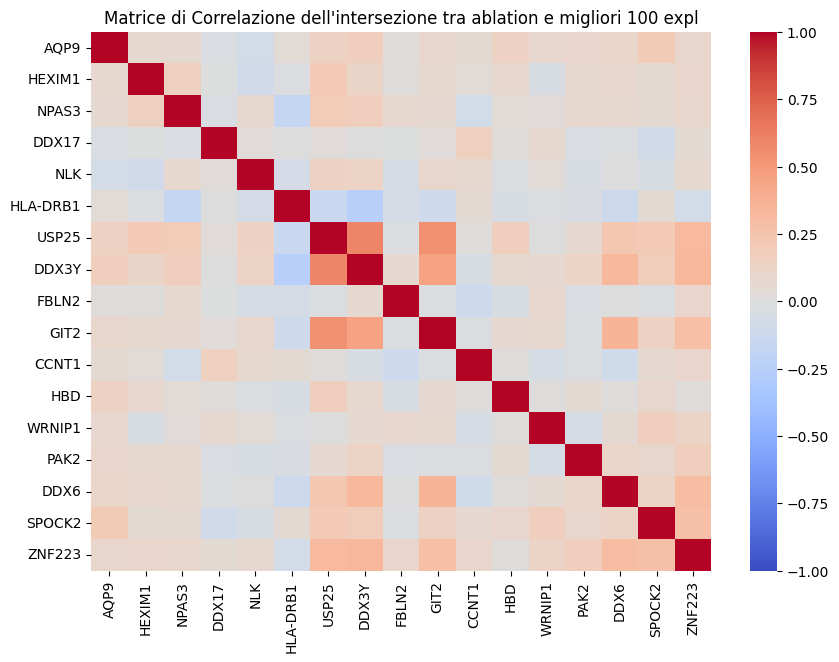

In [20]:
expl = joblib.load('../../ShapValues/DatasetFull/ensemble_expl.pkl')
expl_summary = joblib.load('../../ShapValues/DatasetFull/ensemble_summary.pkl')
expl_dictSummary = dict(zip(x_train.columns, expl_summary))
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

ensemble_ablation = joblib.load("../../ShapValues/DatasetFull/ensembleSoft_ablationScores.pkl")
ensemble_sorted_scores = dict(sorted(ensemble_ablation.items(), key=lambda item: item[1], reverse=True))
ensemble_bestFeatures = {key: value for key, value in ensemble_sorted_scores.items() if value > 1.0}

intersect = set(list(ensemble_bestFeatures.keys())).intersection(set(list(expl_sorted.keys())[:100]))

print(intersect)

intersectCorr = pd.DataFrame(expl, columns=x_train.columns)[list(intersect)].corr()
print(intersectCorr)

plt.figure(figsize=(10,7))
sns.heatmap(intersectCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione dell\'intersezione tra ablation e migliori 100 expl')
plt.show()

In [19]:
intersect_correlated_pairs = np.where(np.abs(intersectCorr) >= 0.375)

# Print the correlated pairs
for i, j in zip(intersect_correlated_pairs[0], intersect_correlated_pairs[1]):
    if i != j:
        print(f"{intersectCorr.index[i]} - {intersectCorr.columns[j]}: {intersectCorr.iloc[i, j]}")

USP25 - DDX3Y: 0.60046097092386
USP25 - GIT2: 0.5418102576880957
DDX3Y - USP25: 0.60046097092386
DDX3Y - GIT2: 0.45959441203321244
GIT2 - USP25: 0.5418102576880957
GIT2 - DDX3Y: 0.45959441203321244


Risultati FeatureSelection

In [54]:
ensemble_featureSelected = joblib.load('../../ShapValues/DatasetFull/ensemble_featureSelected2.pkl')
ensemble_sortedFeature = dict(sorted(ensemble_featureSelected.items(), key=lambda x: x[1], reverse=True))

Score	numFeature	feature
0.9769820971867007	1129	 ('RPL23', 'HLA-DRB1', 'ALDOA', 'GIT2', 'SKI', 'ARHGAP4', 'ZNF223', 'DDX6', 'DPYSL2', 'ASAH1', 'USP25', 'DDX3Y', 'TXNL1', 'EEF1A1', 'IL18', 'HLA-DMB', 'SEMA4D', 'HLA-DRB5', 'ITPR3', 'UTY', 'PPT1', 'ZNF91', 'RENBP', 'CNDP2', 'PITPNM1', 'UQCRFS1', 'NPR1', 'CCNT1', 'FBLN2', 'SUMO3', 'CRNKL1', 'IL6R', 'MPHOSPH9', 'TNK2', 'CSF1R', 'ARHGEF2', 'SMARCA4', 'AKAP13', 'HEXIM1', 'EEF1B2', 'EIF4G2', 'LZTR1', 'TFDP1', 'CRKL', 'PRPF31', 'C1QB', 'PWP1', 'BACH2', 'PPM1A', 'NPFF', 'PHF2', 'WRNIP1', 'SAE1', 'BRD3', 'NFKBIA', 'AQP9', 'SBF1', 'VIM', 'PAK2', 'TM9SF1', 'HECA', 'ENTPD4', 'HBD', 'MXI1', 'RPS29', 'ATF7IP', 'DDX17', 'TLE1', 'CLCC1', 'SPOCK2', 'CCR7', 'UBE2W', 'PPP1R12A', 'IL2RA', 'ADCY7', 'SLC31A1', 'ZNF623', 'SERF2', 'ATP6V0B', 'TMED5', 'MFNG', 'CAST', 'PRDM8', 'RNASET2', 'CAPN1', 'PDK1', 'TUBA1B', 'ACVR1', 'LITAF', 'NLK', 'HOXA10', 'MFN2', 'VPS45', 'RALGPS1', 'MYLIP', 'NPAS3', 'UPK3A', 'TPM3', 'ZBTB11', 'KCTD13', 'PLXND1', 'C11orf58', 'TXNRD1', 

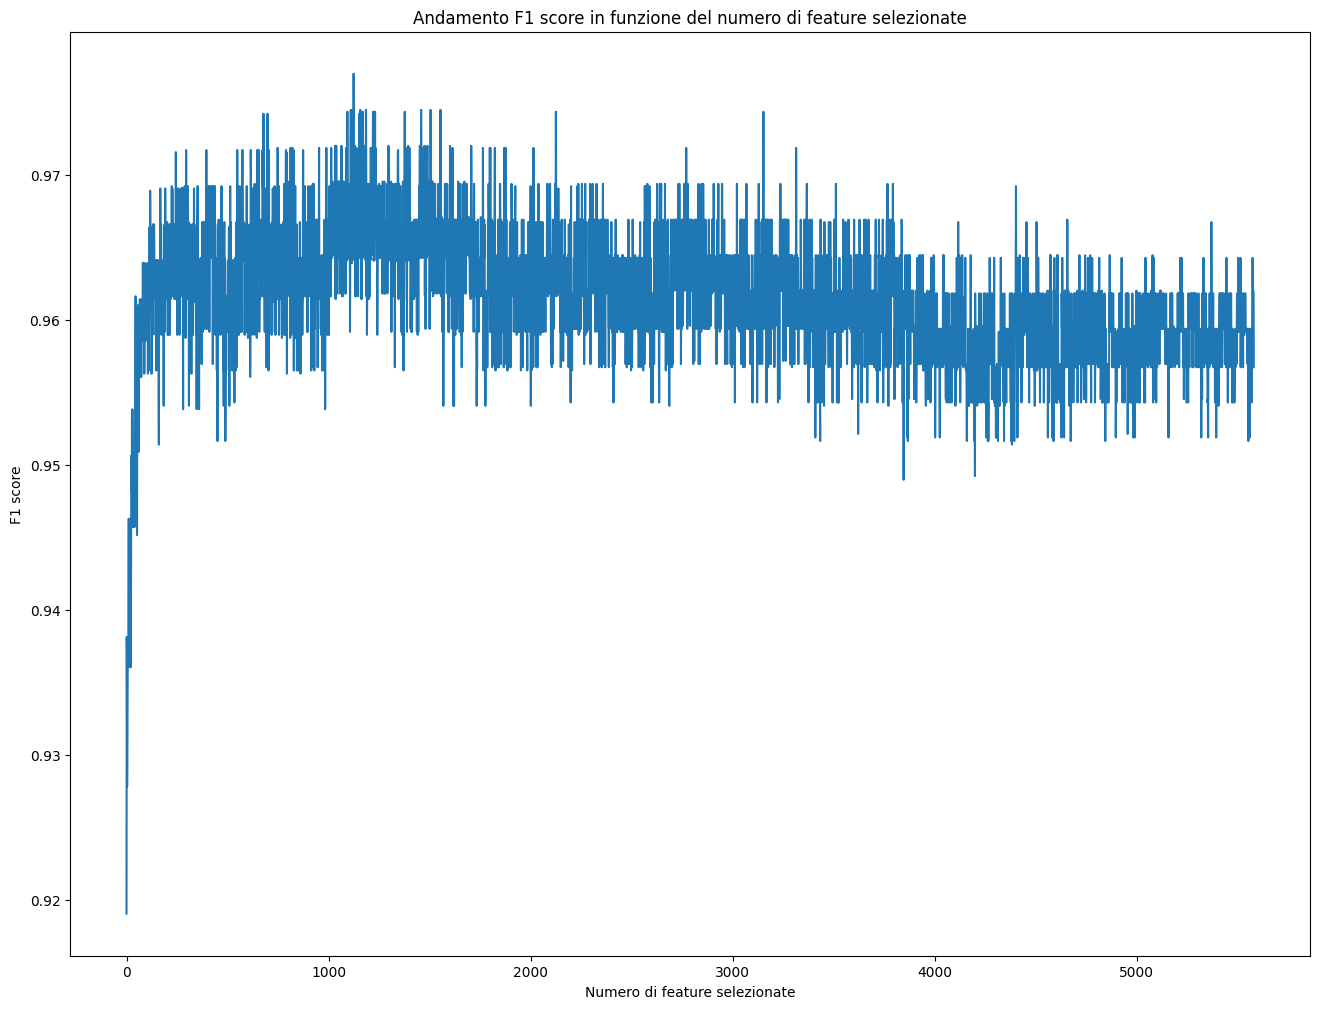

In [7]:
def prettyPrint(sortedFeature):
    print("Score\tnumFeature\tfeature")
    for i in list(sortedFeature.keys())[:50]:
        print(str(sortedFeature[i])+"\t"+str(len(list(i)))+"\t", i)


prettyPrint(ensemble_sortedFeature)

fig, ax = plt.subplots(figsize=(16, 12))

ax.plot(list(ensemble_featureSelected.values()))
ax.set_title("Andamento F1 score in funzione del numero di feature selezionate")
ax.set_xlabel("Numero di feature selezionate")
ax.set_ylabel("F1 score")
plt.show()

Controllo quali delle migliori 100 feature per importance appartengono anche all'insieme selezionato

In [57]:
ensemble_featureSelected = dict(sorted(ensemble_featureSelected.items(), key=lambda x: x[1], reverse=True))

for feature in list(expl_sorted.keys())[:100]:
    if feature in list(ensemble_featureSelected.keys())[0]:
        print(feature)

RPL23
HLA-DRB1
ALDOA
GIT2
SKI
ARHGAP4
ZNF223
DDX6
DPYSL2
ASAH1
USP25
DDX3Y
TXNL1
EEF1A1
IL18
HLA-DMB
SEMA4D
HLA-DRB5
ITPR3
UTY
PPT1
ZNF91
RENBP
CNDP2
PITPNM1
UQCRFS1
NPR1
CCNT1
FBLN2
SUMO3
CRNKL1
IL6R
MPHOSPH9
TNK2
CSF1R
ARHGEF2
SMARCA4
AKAP13
HEXIM1
EEF1B2
EIF4G2
LZTR1
TFDP1
CRKL
PRPF31
C1QB
PWP1
BACH2
PPM1A
NPFF
PHF2
WRNIP1
SAE1
BRD3
NFKBIA
AQP9
SBF1
VIM
PAK2
TM9SF1
HECA
ENTPD4
HBD
MXI1
RPS29
ATF7IP
DDX17
TLE1
CLCC1
SPOCK2
CCR7
UBE2W
PPP1R12A
IL2RA
ADCY7
SLC31A1
ZNF623
SERF2
ATP6V0B
TMED5
MFNG
CAST
PRDM8
RNASET2
CAPN1
PDK1
TUBA1B
ACVR1
LITAF
NLK
HOXA10
MFN2
VPS45
RALGPS1
MYLIP
NPAS3
UPK3A
TPM3
ZBTB11
KCTD13


Ordino i sottoinsieme di feature ottenute mediante featureSelection per importanza (decrescente), e a partire dal migliore sottoinsieme controllo i valori ottenuti con l'ablation per ciascuna di quelle feature, ordinandole in senso crescente

In [28]:
ensemble_featureSelected = dict(sorted(ensemble_featureSelected.items(), key=lambda x: x[1], reverse=True))
print("Il sottoinsieme migliore di feature conta: ", len(list(ensemble_featureSelected.keys())[0]), "elementi, che sono: ", list(ensemble_featureSelected.keys())[0])

ensemble_ablation = dict(sorted(ensemble_ablation.items(), key=lambda x: x[1], reverse=True))
ensemble_ablationSubset = {key: value for key, value in ensemble_ablation.items() if key in list(ensemble_featureSelected.keys())[0]}
ensemble_ablationSubsetSorted = dict(sorted(ensemble_ablationSubset.items(), key=lambda x: x[1]))
print(ensemble_ablationSubsetSorted)

Il sottoinsieme migliore di feature conta:  1129 elementi, che sono:  ('RPL23', 'HLA-DRB1', 'ALDOA', 'GIT2', 'SKI', 'ARHGAP4', 'ZNF223', 'DDX6', 'DPYSL2', 'ASAH1', 'USP25', 'DDX3Y', 'TXNL1', 'EEF1A1', 'IL18', 'HLA-DMB', 'SEMA4D', 'HLA-DRB5', 'ITPR3', 'UTY', 'PPT1', 'ZNF91', 'RENBP', 'CNDP2', 'PITPNM1', 'UQCRFS1', 'NPR1', 'CCNT1', 'FBLN2', 'SUMO3', 'CRNKL1', 'IL6R', 'MPHOSPH9', 'TNK2', 'CSF1R', 'ARHGEF2', 'SMARCA4', 'AKAP13', 'HEXIM1', 'EEF1B2', 'EIF4G2', 'LZTR1', 'TFDP1', 'CRKL', 'PRPF31', 'C1QB', 'PWP1', 'BACH2', 'PPM1A', 'NPFF', 'PHF2', 'WRNIP1', 'SAE1', 'BRD3', 'NFKBIA', 'AQP9', 'SBF1', 'VIM', 'PAK2', 'TM9SF1', 'HECA', 'ENTPD4', 'HBD', 'MXI1', 'RPS29', 'ATF7IP', 'DDX17', 'TLE1', 'CLCC1', 'SPOCK2', 'CCR7', 'UBE2W', 'PPP1R12A', 'IL2RA', 'ADCY7', 'SLC31A1', 'ZNF623', 'SERF2', 'ATP6V0B', 'TMED5', 'MFNG', 'CAST', 'PRDM8', 'RNASET2', 'CAPN1', 'PDK1', 'TUBA1B', 'ACVR1', 'LITAF', 'NLK', 'HOXA10', 'MFN2', 'VPS45', 'RALGPS1', 'MYLIP', 'NPAS3', 'UPK3A', 'TPM3', 'ZBTB11', 'KCTD13', 'PLXND1', 'C

Feature importanti per ablation appartenenti a featureSelected

In [29]:
def resume(ablationSubsetSorted):
    result = {'-1':0, '0':0, '1':0}
    for key, value in ablationSubsetSorted.items():
        if value < 1:
            result['-1'] += 1
        elif value == 1.0:
            result['0'] += 1
        else:
            result['1'] += 1
    return result

print(resume(ensemble_ablationSubsetSorted))

ensemble_best = []
for key, value in ensemble_ablationSubsetSorted.items():
        if value > 1: 
            print(key, ":", value)
            ensemble_best.append(key)

print(ensemble_best)

{'-1': 36, '0': 1063, '1': 30}
NRG1 : 1.002
SP100 : 1.002
PCBD1 : 1.002
ZNF223 : 1.002
GNL3 : 1.002
CDKN2D : 1.002
DDX6 : 1.002
SH3YL1 : 1.002
C1QB : 1.002
WRNIP1 : 1.002
LRP10 : 1.002
TLE1 : 1.002
EEF1A1 : 1.002
GPR132 : 1.002
EIF4G2 : 1.002
TUBA1B : 1.002
COG5 : 1.002
AHI1 : 1.002
CCNT1 : 1.002
ZNF91 : 1.002
AQP9 : 1.002
RFTN1 : 1.002
C5orf22 : 1.002
PICALM : 1.002
ZNF623 : 1.002
DDX3Y : 1.002
SEMA6C : 1.002
SKI : 1.0022288135593223
HBD : 1.004
HLA-DRB1 : 1.0064936170212768
['NRG1', 'SP100', 'PCBD1', 'ZNF223', 'GNL3', 'CDKN2D', 'DDX6', 'SH3YL1', 'C1QB', 'WRNIP1', 'LRP10', 'TLE1', 'EEF1A1', 'GPR132', 'EIF4G2', 'TUBA1B', 'COG5', 'AHI1', 'CCNT1', 'ZNF91', 'AQP9', 'RFTN1', 'C5orf22', 'PICALM', 'ZNF623', 'DDX3Y', 'SEMA6C', 'SKI', 'HBD', 'HLA-DRB1']


La probabilità è il risultato dell'ensemble, i valori al centro sono le treshold con annessa importanca calcolate per questo esempio e la tabella a destra rappresenta i valori assuni dalle feature

In [7]:
limeexplanation[0].show_in_notebook(show_table=True)

In [11]:
expl = joblib.load('../../ShapValues/DatasetFull/ensemble_expl.pkl')
expl_summary = np.abs(expl).mean(0)
expl_dictSummary = dict(zip(x_train.columns, expl_summary))
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

ablation1 = joblib.load('../../ShapValues/DatasetFull/ensemble_ablationScores.pkl')
ablation2 = joblib.load('../../ShapValues/DatasetFull/ensembleSoft_ablationScores.pkl')

ensemble_sorted_scores1 = dict(sorted(ablation1.items(), key=lambda item: item[1], reverse=True))
ensemble_bestFeatures_1 = {key: value for key, value in ensemble_sorted_scores1.items() if value > 1.0}
ensemble_worstFeatures_1 = {key: value for key, value in ensemble_sorted_scores1.items() if value < 1.0}

ensemble_sorted_scores2 = dict(sorted(ablation2.items(), key=lambda item: item[1], reverse=True))
ensemble_bestFeatures_2 = {key: value for key, value in ensemble_sorted_scores2.items() if value > 1.0}
ensemble_worstFeatures_2 = {key: value for key, value in ensemble_sorted_scores2.items() if value < 1.0}

print(ensemble_bestFeatures_1.keys())
print(ensemble_bestFeatures_2.keys())

dict_keys(['HLA-DRB1', 'HBD', 'SKI', 'NRG1', 'SP100', 'PCBD1', 'FIP1L1', 'ZNF223', 'GNL3', 'CDKN2D', 'DDX6', 'ATG12', 'CEP192', 'BASP1', 'SH3YL1', 'C1QB', 'WRNIP1', 'LRP10', 'MTSS1', 'TLE1', 'GFRA2', 'EEF1A1', 'ACTB', 'ATXN3', 'CD63', 'GPR132', 'EIF4G2', 'RAP1A', 'TUBA1B', 'ZNF224', 'COG5', 'ZAP70', 'AHI1', 'CCNT1', 'KLF6', 'ZNF91', 'CEACAM6', 'AQP9', 'RFTN1', 'GGA1', 'C5orf22', 'RAD21', 'PICALM', 'MAF', 'ZNF623', 'NOL11', 'DDX3Y', 'STAM', 'SEMA6C', 'KIAA0040', 'CTSA'])
dict_keys(['HLA-DRB1', 'GIT2', 'NLK', 'DDX17', 'HDAC9', 'UEVLD', 'LAPTM4B', 'UTP14A', 'USP25', 'ESRRA', 'CCNT1', 'VAPB', 'SAFB', 'NPAS3', 'ZNF223', 'HBD', 'DDX6', 'WRNIP1', 'USP33', 'FBLN2', 'SUMO4', 'TSPAN32', 'TGFBRAP1', 'SPOCK2', 'AQP9', 'DDX3Y', 'PAK2', 'PRKAG2', 'SMARCB1', 'HEXIM1'])


In [13]:
print([feature for feature in list(ensemble_bestFeatures_1.keys()) if feature in list(expl_sorted.keys())[:100]])
print([feature for feature in list(ensemble_bestFeatures_2.keys()) if feature in list(expl_sorted.keys())[:100]])

['HLA-DRB1', 'HBD', 'SKI', 'ZNF223', 'DDX6', 'C1QB', 'WRNIP1', 'TLE1', 'EEF1A1', 'EIF4G2', 'TUBA1B', 'CCNT1', 'ZNF91', 'AQP9', 'ZNF623', 'DDX3Y']
['HLA-DRB1', 'GIT2', 'NLK', 'DDX17', 'USP25', 'CCNT1', 'NPAS3', 'ZNF223', 'HBD', 'DDX6', 'WRNIP1', 'FBLN2', 'SPOCK2', 'AQP9', 'DDX3Y', 'PAK2', 'HEXIM1']
